Work on [NCL's zonal_mpsi](https://www.ncl.ucar.edu/Document/Functions/Built-in/zonal_mpsi.shtml) with a UXarray dataset.

Zonal mean meridional stream function

*v*: A multi-dimensional array of meridional wind values

*lat*: A one-dimensional array of latitudes.

*p*: A one-dimensional array of pressure level values ordered top-to-bottom.

*ps*: A multi-dimensional numeric array of surface pressures.

$MPSI(lev,lat) = \frac{2 {\pi} a cos(lat)}{g} \int_{p}^{PS} \bar{v} \,dp$

In [1]:
import uxarray as ux
import xarray as xr
import numpy as np

In [3]:
# Constants
a = 6.371e6  # Earth radius (m)
g = 9.80665  # gravity (m/s^2)

Need a datset with: wind speed values (lat, long, time, maybe lev), vertical pressure levels, and spatial surface pressure

In [2]:
data_path = '../data/zonal_mpsi/e2p3b09.F2000climo.ne30pg3.ctl002.cam.h0.0005-01.nc'
grid_path = '../data/zonal_mpsi/ne30pg3_scrip_170604.nc'

uxds = ux.open_dataset(grid_path, data_path)
uxds

<xarray.UxDataset> Size: 182MB
Dimensions:        (n_face: 48600, lev: 32, ilev: 33, time: 1, nbnd: 2)
Coordinates:
  * lev            (lev) float64 256B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev           (ilev) float64 264B 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * time           (time) object 8B 0005-02-01 00:00:00
Dimensions without coordinates: n_face, nbnd
Data variables: (12/120)
    lat            (n_face) float64 389kB ...
    lon            (n_face) float64 389kB ...
    area           (n_face) float64 389kB ...
    hyam           (lev) float64 256B ...
    hybm           (lev) float64 256B ...
    hyai           (ilev) float64 264B ...
    ...             ...
    VV             (time, lev, n_face) float32 6MB ...
    WSPDSRFAV      (time, n_face) float32 194kB ...
    WSPDSRFMX      (time, n_face) float32 194kB ...
    Z3             (time, lev, n_face) float32 6MB ...
    uIVT           (time, n_face) float32 194kB ...
    vIVT           (time, n_face) float32 194kB ...

The data hasn't been interpolated to pressure levels (still on hybrid sigma levels)

In [57]:
# Grabbing correct data variables, confirming long names
print(uxds.lat.attrs['long_name'],', ',
      uxds.PS.attrs['long_name'],', ',
      uxds.V.attrs['long_name'],', ',
      uxds.hyam.attrs['long_name'],', ', 
      uxds.hybm.attrs['long_name'],', ',
      uxds.hyai.attrs['long_name'],', ', 
      uxds.hybi.attrs['long_name'])

latitude ,  Surface pressure ,  Meridional wind ,  hybrid A coefficient at layer midpoints ,  hybrid B coefficient at layer midpoints ,  hybrid A coefficient at layer interfaces ,  hybrid B coefficient at layer interfaces


In [74]:
# Convert sigma hybrid coordinates to pressure levels

p0 = 100000
pm = uxds.hyam * p0 + uxds.hybm * uxds.PS
pm.attrs['long_name'] = 'pressure midpoints'
pm.attrs['units'] = 'Pa'
uxds = uxds.assign({"pm":pm})

pi = uxds.hyai * p0 + uxds.hybi * uxds.PS
pi.attrs['long_name'] = 'pressure interfaces'
pi.attrs['units'] = 'Pa'
uxds = uxds.assign({"pi":pi})

In [75]:
scaling_factor = 2 * np.pi * a * np.cos(uxds.lat) / g

# zonal mean wind
v_zonal = uxds.V.zonal_mean()

# zonal mean on integration bounds
PS_zonal = uxds.PS.zonal_mean()
pm_zonal = uxds.pm.zonal_mean()
pi_zonal = uxds.pi.zonal_mean()

In [70]:
# Calculate dp from pressure interfaces
dp = pi_zonal.isel(ilev=slice(1, None)) - pi_zonal.isel(ilev=slice(None, -1))

In [71]:

# Mask out levels above the surface (where p_i > PS_zonal)
mask = pi_zonal.isel(ilev=slice(1, None)) <= PS_zonal
dp = dp.where(mask)
v_masked = v_zonal.where(mask)

In [72]:
# Integrate v*dp from each level to the surface (cumulative sum from top)
mpsi = (v_masked * dp).cumsum(dim='ilev')

# Apply scaling factor (broadcast to shape)
mpsi = scaling_factor * mpsi
mpsi

<xarray.DataArray (n_face: 48600, time: 1, lev: 32, latitudes: 19, ilev: 32)> Size: 8GB
array([[[[[-1.19129245e+06, -3.39081499e+06, -6.99387451e+06, ...,
           -2.81094074e+08, -2.85657701e+08, -2.89989414e+08],
          [-3.06465612e+06, -8.72303185e+06, -1.79920728e+07, ...,
           -8.37956785e+08, -8.52265364e+08, -8.65183106e+08],
          [-6.35414144e+06, -1.80860024e+07, -3.73040793e+07, ...,
           -1.97829735e+09, -2.01335275e+09, -2.01335275e+09],
          ...,
          [ 3.35602827e+09,  9.55237398e+09,  1.97026688e+10, ...,
            1.13608124e+12,  1.15663650e+12,  1.15663650e+12],
          [ 3.42703338e+09,  9.75447818e+09,  2.01195277e+10, ...,
            1.16241916e+12,  1.18346080e+12,  1.20138828e+12],
          [ 3.22829077e+08,  9.18879055e+08,  1.89527438e+09, ...,
            1.12793246e+11,  1.14849029e+11,  1.14849029e+11]],

         [[-8.61216271e+05, -2.45130829e+06, -5.05605366e+06, ...,
           -2.03210212e+08, -2.06509376e+08, -2.09640884e+08],
          [ 1.15588870e+06,  3.29004414e+06,  6.78602516e+06, ...,
            3.16050068e+08,  3.21446799e+08,  3.26318952e+08],
          [ 6.77221073e+05,  1.92759668e+06,  3.97584927e+06, ...,
            2.10845898e+08,  2.14582084e+08,  2.14582084e+08],
...
          [-3.02373256e+08, -8.60654977e+08, -1.77518175e+09, ...,
           -1.02359264e+11, -1.04211263e+11, -1.04211263e+11],
          [-8.13304655e+07, -2.31493588e+08, -4.77477274e+08, ...,
           -2.75865686e+10, -2.80859295e+10, -2.85113851e+10],
          [-2.35013847e+07, -6.68927667e+07, -1.37972616e+08, ...,
           -8.21114841e+09, -8.36080575e+09, -8.36080575e+09]],

         [[-1.63811655e+08, -4.66262519e+08, -9.61710254e+08, ...,
           -3.86525455e+10, -3.92800785e+10, -3.98757216e+10],
          [-7.39509603e+07, -2.10489058e+08, -4.34153459e+08, ...,
           -2.02201182e+10, -2.05653879e+10, -2.08770965e+10],
          [-5.36690930e+08, -1.52760110e+09, -3.15082080e+09, ...,
           -1.67093266e+11, -1.70054156e+11, -1.70054156e+11],
          ...,
          [-3.52026447e+08, -1.00198449e+09, -2.06668715e+09, ...,
           -1.19167840e+11, -1.21323960e+11, -1.21323960e+11],
          [-1.69622360e+08, -4.82801720e+08, -9.95823908e+08, ...,
           -5.75343918e+10, -5.85758559e+10, -5.94631838e+10],
          [-9.87529281e+06, -2.81083718e+07, -5.79761577e+07, ...,
           -3.45032839e+09, -3.51321447e+09, -3.51321447e+09]]]]])
Coordinates:
  * latitudes  (latitudes) int64 152B -90 -80 -70 -60 -50 -40 ... 50 60 70 80 90
Dimensions without coordinates: n_face, time, lev, ilev

In [ ]:
mpsi.isel(time=0, lev=20)

<xarray.DataArray (n_face: 48600, latitudes: 19, ilev: 32)> Size: 236MB
array([[[ 2.58138364e+07,  7.34747744e+07,  1.51548625e+08, ...,
          6.09096152e+09,  6.18984968e+09,  6.28371256e+09],
        [-2.81733961e+08, -8.01908670e+08, -1.65401197e+09, ...,
         -7.70334011e+10, -7.83487893e+10, -7.95363179e+10],
        [ 1.11162949e+08,  3.16406769e+08,  6.52618689e+08, ...,
          3.46094542e+10,  3.52227332e+10,  3.52227332e+10],
        ...,
        [-1.53205016e+08, -4.36072492e+08, -8.99440485e+08, ...,
         -5.18628957e+10, -5.28012578e+10, -5.28012578e+10],
        [-1.69528123e+08, -4.82533490e+08, -9.95270660e+08, ...,
         -5.75024276e+10, -5.85433131e+10, -5.94301479e+10],
        [-8.13595373e+05, -2.31576335e+06, -4.77647950e+06, ...,
         -2.84262074e+08, -2.89443067e+08, -2.89443067e+08]],

       [[ 1.74285143e+07,  4.96073554e+07,  1.02319831e+08, ...,
          4.11238409e+09,  4.17914959e+09,  4.24252221e+09],
        [-1.90215987e+08, -5.41418041e+08, -1.11672558e+09, ...,
         -5.20100040e+10, -5.28981038e+10, -5.36998776e+10],
        [ 7.50529683e+07,  2.13625740e+08,  4.40623160e+08, ...,
          2.33669788e+10,  2.37810413e+10,  2.37810413e+10],
...
        [ 1.30824607e+07,  3.72370396e+07,  7.68048928e+07, ...,
          4.42866894e+09,  4.50879742e+09,  4.50879742e+09],
        [ 1.44763211e+07,  4.12044305e+07,  8.49880093e+07, ...,
          4.91023904e+09,  4.99912218e+09,  5.07485066e+09],
        [ 6.94744192e+04,  1.97747332e+05,  4.07872451e+05, ...,
          2.42736662e+07,  2.47160808e+07,  2.47160808e+07]],

       [[ 1.10352756e+07,  3.14100689e+07,  6.47862183e+07, ...,
          2.60385313e+09,  2.64612728e+09,  2.68625316e+09],
        [-1.20439746e+08, -3.42811622e+08, -7.07081179e+08, ...,
         -3.29313626e+10, -3.34936840e+10, -3.40013460e+10],
        [ 4.75215598e+07,  1.35262184e+08,  2.78990962e+08, ...,
          1.47953546e+10,  1.50575281e+10,  1.50575281e+10],
        ...,
        [-6.54943162e+07, -1.86418633e+08, -3.84505946e+08, ...,
         -2.21711076e+10, -2.25722523e+10, -2.25722523e+10],
        [-7.24723564e+07, -2.06280459e+08, -4.25472828e+08, ...,
         -2.45819770e+10, -2.50269499e+10, -2.54060670e+10],
        [-3.47807624e+05, -9.89976317e+05, -2.04191917e+06, ...,
         -1.21520500e+08, -1.23735347e+08, -1.23735347e+08]]])
Coordinates:
  * latitudes  (latitudes) int64 152B -90 -80 -70 -60 -50 -40 ... 50 60 70 80 90
Dimensions without coordinates: n_face, ilev

(array([   65064.,    70872.,   512936.,  1618776., 12493328., 12523136.,
         1615000.,   514328.,    71384.,    63976.]),
 array([-1.47598347e+11, -1.18078670e+11, -8.85589933e+10, -5.90393163e+10,
        -2.95196393e+10,  3.77343850e+04,  2.95197148e+10,  5.90393918e+10,
         8.85590688e+10,  1.18078746e+11,  1.47598423e+11]),
 <BarContainer object of 10 artists>)

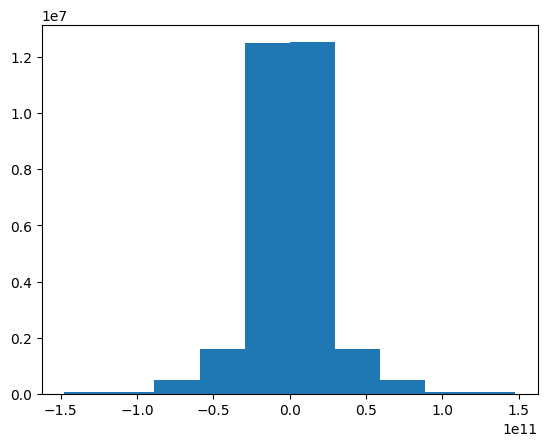

In [84]:
mpsi.isel(time=0, lev=20).plot()

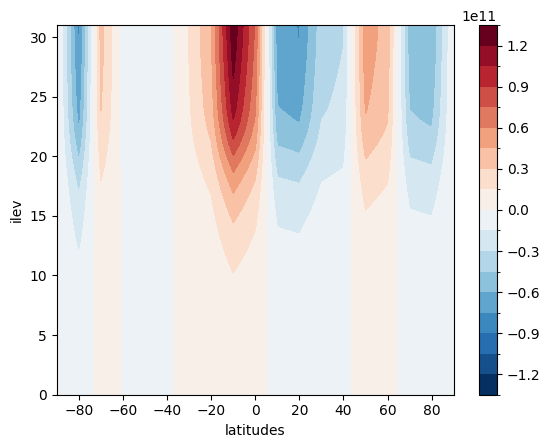

In [88]:
# Select a single n_face (e.g., the first one) for plotting
mpsi.isel(n_face=0, time=0, lev=20).plot.contourf(x='latitudes', y='ilev', levels=20, add_colorbar=True)

I'm getting confused about how my mpsi has both ilev (from interface pressures) and lev (from midpoint pressures). These are linked, in that I probably want to drop one of them.

Also having latitude as a variable separate from the grid information. I'll want to touch base on this.